In [2]:
# Data: time-serie data from smartwatch or smartwatch data
# %matplotlib inline # for plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
# data_path = 'data/financial_data/USD_INR.csv'
# data_path = 'data/bike_data/hour.csv'
data_path = 'data/financial_data/USD_INR.csv'
data = pd.read_csv(data_path)

# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# Showing the data file csv or comma separated value
data[:10]

,Date,Price,Open,High,Low,Change %
0,"Aug 10, 2017",64.165,63.898,64.175,63.855,0.48
1,"Aug 09, 2017",63.860,63.780,63.860,63.710,0.26
2,"Aug 08, 2017",63.692,63.750,63.785,63.615,-0.23
3,"Aug 07, 2017",63.840,63.710,63.865,63.648,0.26
4,"Aug 04, 2017",63.675,63.670,63.786,63.572,-0.05
5,"Aug 03, 2017",63.705,63.630,63.720,63.560,0.11
6,"Aug 02, 2017",63.635,64.120,64.135,63.590,-0.72
7,"Aug 01, 2017",64.095,64.100,64.145,64.040,-0.16
8,"Jul 31, 2017",64.200,64.110,64.272,64.045,0.13
9,"Jul 28, 2017",64.115,64.190,64.245,64.105,-0.02


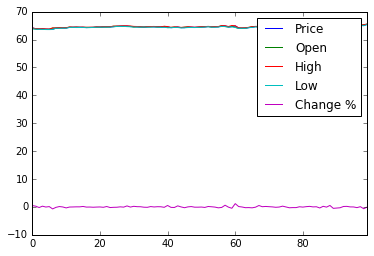

In [18]:
# # Plotting the smartwatch data before scaling/batch normalization
# data[:10000]['Price'].plot()
data[: 100].plot()
plt.legend()
plt.show()

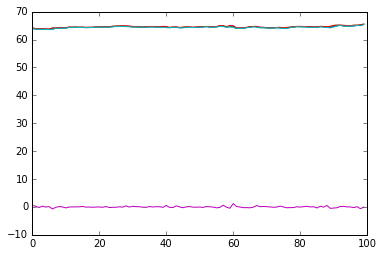

In [19]:
data_array = np.array(data)
data_array.shape, data_array.dtype
data_main = np.array(data_array[:, 1:], dtype=float)
data_main.shape, data_main.dtype

plt.plot(data_main[:100])
plt.show()

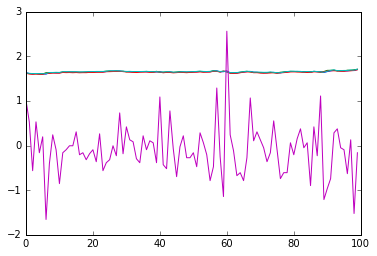

(8.49984091452734e-18, 1.0, 1.0000000000000002, (9697, 5), dtype('float64'))

In [20]:
mean = np.mean(data_main, axis=0)
std = np.std(data_main, axis=0)
std.shape, mean.shape, std.dtype, mean.dtype

data_norm = (data_main - mean) / std
plt.plot(data_norm[:100])
plt.show()
data_norm.mean(), data_norm.std(), data_norm.var(), data_norm.shape, data_norm.dtype

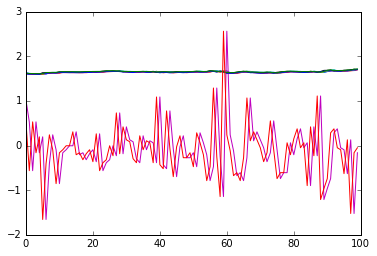

In [21]:
train_data = data_norm[:9000] # the last dim/variable/feature, 9,697, 697
test_data = data_norm[9000:] # the last dim/variable/feature
train_data.shape, test_data.shape
X_train = train_data[0:8999]
Y_train = train_data[1:9000]
X_train.shape, Y_train.shape

plt.plot(X_train[:100])
plt.plot(Y_train[:100])
plt.show()

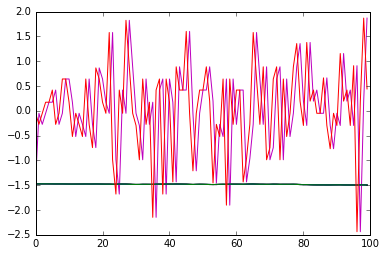

In [22]:
X_valid = test_data[0:696] 
Y_valid = test_data[1:697]
X_valid.shape, Y_valid.shape
plt.plot(X_valid[:100])
plt.plot(Y_valid[:100])
plt.show()

In [23]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, p_dropout, lam):
        self.D = D
        self.H = H
        self.p_dropout = p_dropout
        self.lam = lam
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = m
        
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, 
                 y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches, do_caches = [], [], []

        for X in X_train:
            X = X.reshape(1, -1) # X_1xn
            y, h, cache = self.forward(X, h, self.model)
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            caches.append(cache)
            do_caches.append(do_cache)
            ys.append(y)
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        
        return ys, caches, do_caches
                                
    def loss_function(self, y_pred, y_train): # , alpha alpha: learning rate
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += l2_regression_reg(model=self.model, y_pred=y, y_train=Y, lam=self.lam)
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches, do_caches):
        dh = np.zeros((1, self.H)) 
        grad = {key: np.zeros_like(val) for key, val in self.model.items()}
        grads= {key: np.zeros_like(val) for key, val in self.model.items()}

        for t in reversed(range(len(dys))):
            dy = dys[t].reshape(1, -1) # dy_1xn
            dy = l.dropout_backward(dy, do_caches[t])
            _, dh, grad = self.backward(dy, dh, caches[t])
            for key in grad.keys():
                grads[key] += grad[key]
                
        return grads
    
    def test(self, X_seed, h, size):
        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            y, h, _ = self.forward(X, h, self.model)
            X = y.copy() # previous out for the next input for prediction
            ys.append(y) # list array
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        return ys

In [24]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, XY_train, XY_valid, alpha, mb_size, n_iter, print_after):
    X_train, y_train = XY_train
    X_valid, y_valid = XY_valid

    M= {key: np.zeros_like(val) for key, val in nn.model.items()}
    R= {key: np.zeros_like(val) for key, val in nn.model.items()}
    
    # Learning decay: suggested by Justin Jhonson in Standford
    beta1 = .9
    beta2 = .99
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            
            # Train the model
            X_mini, y_mini = minibatches[idx]
            ys, caches, do_caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini) #, alpha=alpha
            grads = nn.train_backward(dys, caches, do_caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            # Update the model
            for key in grads.keys(): #key, value: items
                M[key] = l.exp_running_avg(M[key], grads[key], beta1)
                R[key] = l.exp_running_avg(R[key], grads[key]**2, beta2)
                m_k_hat = M[key] / (1. - (beta1** iter))
                r_k_hat = R[key] / (1. - (beta2** iter))
                nn.model[key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate the model (by testing)
            ys = nn.test(X_seed=X_valid[0], h=state, size=X_valid.shape[0]) # ys_tx1xn
            valid_loss, _ = nn.loss_function(y_pred=ys, y_train=Y_valid) #, alpha=alpha
            nn.losses['valid'].append(valid_loss)

        # Print the model loss/ error
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.8f}, valid loss: {:.8f}'.format(iter, loss, valid_loss))

    return nn

In [ ]:
# Hyper-parameters
time_step = 128 # minibatch size: 32, 64, 128, or 256 Cache
n_iter = 1000 # epochs
alpha = 1e-4 # learning_rate: 1e-3, 5e-4, 1e-4 - default choices
print_after = 1 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = X_train.shape[1] # X_txn
keep_prob = 0.95 # p_dropout == keep_prob: keeping neurons/units - default 0.95 to 0.9 based on SELU-Dropout
lam = 1e-4 # regularization

# Build the network and learning it or optimizing it using SGD
# def adam_rnn(nn, X_train, y_train, alpha=0.001, mb_size=256, n_iter=2000, print_after=100):
net = GRU(D=num_input_units, H=num_hidden_units, p_dropout=keep_prob, lam=lam) #, L=num_layers, p_dropout=p_dropout

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, XY_train=(X_train, Y_train), XY_valid=(X_valid, Y_valid), alpha=alpha, mb_size=time_step,
         n_iter=n_iter, print_after=print_after)

Iter-1, train loss: 26.18145155, valid loss: 730.29228576
Iter-2, train loss: 17.14181781, valid loss: 665.36436458
Iter-3, train loss: 12.01773797, valid loss: 402.53381503
Iter-4, train loss: 10.73105078, valid loss: 248.00385273
Iter-5, train loss: 8.95765424, valid loss: 176.02984756
Iter-6, train loss: 9.60291397, valid loss: 141.11780686
Iter-7, train loss: 9.03502782, valid loss: 124.15782580
Iter-8, train loss: 7.59452932, valid loss: 115.37814368
Iter-9, train loss: 7.23824779, valid loss: 110.42845477
Iter-10, train loss: 6.95693447, valid loss: 107.77207331
Iter-11, train loss: 7.00035512, valid loss: 106.14270658
Iter-12, train loss: 8.28614427, valid loss: 104.81092939
Iter-13, train loss: 6.63530640, valid loss: 104.22523405
Iter-14, train loss: 7.25955584, valid loss: 103.75113185
Iter-15, train loss: 6.93314382, valid loss: 103.67111954
Iter-16, train loss: 7.06967027, valid loss: 103.41388358
Iter-17, train loss: 7.62643659, valid loss: 103.28402310
Iter-18, train loss

Iter-142, train loss: 4.96650105, valid loss: 598.91296111
Iter-143, train loss: 4.32025747, valid loss: 603.62285080
Iter-144, train loss: 4.08745706, valid loss: 591.69173412
Iter-145, train loss: 4.34209415, valid loss: 574.11813609
Iter-146, train loss: 5.38658398, valid loss: 558.84372651
Iter-147, train loss: 5.60930785, valid loss: 535.42132670
Iter-148, train loss: 4.31584181, valid loss: 515.20367288
Iter-149, train loss: 5.15726338, valid loss: 500.73396882
Iter-150, train loss: 4.96080721, valid loss: 456.07993093
Iter-151, train loss: 4.52730966, valid loss: 513.87570916
Iter-152, train loss: 4.79195400, valid loss: 505.63729028
Iter-153, train loss: 4.52153396, valid loss: 521.67034065
Iter-154, train loss: 4.28241474, valid loss: 504.97502985
Iter-155, train loss: 4.48758373, valid loss: 504.79815536
Iter-156, train loss: 5.65310997, valid loss: 499.31470984
Iter-157, train loss: 4.28123088, valid loss: 486.40910011
Iter-158, train loss: 4.76203702, valid loss: 522.127857

Iter-282, train loss: 5.30453950, valid loss: 96.46198770
Iter-283, train loss: 3.52851840, valid loss: 92.22055686
Iter-284, train loss: 4.99677665, valid loss: 98.62224676
Iter-285, train loss: 4.62674170, valid loss: 106.48713648
Iter-286, train loss: 4.40790032, valid loss: 102.70119670
Iter-287, train loss: 4.86139290, valid loss: 106.91092652
Iter-288, train loss: 4.91956033, valid loss: 93.97269956
Iter-289, train loss: 3.75849349, valid loss: 102.58433122
Iter-290, train loss: 5.29469949, valid loss: 105.51049863
Iter-291, train loss: 4.46675436, valid loss: 103.60533687
Iter-292, train loss: 4.62443093, valid loss: 88.65751065
Iter-293, train loss: 5.01596900, valid loss: 99.42841319
Iter-294, train loss: 4.39602960, valid loss: 97.31236941
Iter-295, train loss: 3.96837692, valid loss: 100.17060609
Iter-296, train loss: 5.11517536, valid loss: 101.61878835
Iter-297, train loss: 4.24441675, valid loss: 101.70679777
Iter-298, train loss: 3.95710573, valid loss: 88.95685108
Iter-

Iter-422, train loss: 4.04101655, valid loss: 87.31469792
Iter-423, train loss: 4.69215410, valid loss: 100.49505829
Iter-424, train loss: 4.91806511, valid loss: 92.68298880
Iter-425, train loss: 4.02226779, valid loss: 155.02652538
Iter-426, train loss: 4.92505432, valid loss: 90.89968039
Iter-427, train loss: 4.02157208, valid loss: 89.15707311
Iter-428, train loss: 3.83532530, valid loss: 103.58916094
Iter-429, train loss: 5.33244313, valid loss: 169.89676817
Iter-430, train loss: 4.64666042, valid loss: 93.27382562
Iter-431, train loss: 4.90720538, valid loss: 160.92862544
Iter-432, train loss: 4.67233652, valid loss: 92.79396199
Iter-433, train loss: 5.33429553, valid loss: 186.14027970
Iter-434, train loss: 4.23643870, valid loss: 89.60084220
Iter-435, train loss: 3.80824846, valid loss: 137.96065674
Iter-436, train loss: 4.67152176, valid loss: 90.10408635
Iter-437, train loss: 5.34066774, valid loss: 153.49876686
Iter-438, train loss: 4.12689871, valid loss: 90.14624448
Iter-4

In [ ]:
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

y_pred = net.test(X_seed=X_valid[0], h=net.initial_state(), size=X_valid.shape[0]) # ys_tx1xn
y_pred.shape, Y_valid.shape

plt.plot(y_pred[:300], label='y_pred')
plt.plot(Y_valid[:300], label='Y_valid')
# plt.plot(X_valid, label='X_valid')
plt.legend()
plt.show()